<a href="https://colab.research.google.com/github/gabrielcz6/supermarketsalesanalysis/blob/main/Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [KeplerSciCon Breakout Session](https://keplerscience.arc.nasa.gov/scicon-2019/): Lightkurve Tutorial

[Christina Hedges](https://twitter.com/TheChedgehog), [Geert Barentsen](https://twitter.com/geerthub), [Nick Saunders](https://twitter.com/nksaunders), [Zé Vinícius](https://twitter.com/mircaze),  and collaborators.*

In this tutorial, we will demonstrate the new `lightkurve` package, which you can read all about [here](http://docs.lightkurve.org/tutorials/). We will demonstrate the workflow of lightkurve for TESS data, and show off a few of our tools for planet detection.


## Table of Contents

* [1. Getting Started](#1.-Getting-Started)
* [2. Introduction](#2.-Introduction)
* [3. Lightkurve workflow](#3.-Lightkurve-workflow)
   * [3.1. Working with a TPF](#3.1-Working-with-a-TPF)
   * [3.2. Working with Light Curves](#3.2-Working-with-Light-Curves)
* [4. Making Simple Corrections to Light Curves](#4.-Making-simple-corrections-to-light-curves)
    * [4.1 Folding Light Curves](#4.1-Folding-Light-Curves)
    * [4.2 Stringing Commands Together](#4.2-Stringing-Commands-Together)
* [5. Converting Light Curves to Other Formats](#5.-Converting-light-curves-to-other-formats)
* [6. Searching for Targets](#6.-Searching-for-Targets)
    * [6.1 Radius Queries](#6.1-Radius-Queries)
    * [6.2 Obtaining TESS FFI Cut-outs](#6.2-Obtaining-TESS-FFI-Cut-outs)
    * [6.3 Stitching Light Curves](#6.3-Stitching-Light-Curves)
* [7. Periodograms](#7.-Periodograms)
    * [7.1 BLS Periodograms](#7.1-BLS-Periodograms)
    * [7.2 Interactively searching with BLS](#7.2-Interactively-searching-with-BLS)
* [8. Troubleshooting and Contributing](#8.-Troubleshooting-and-Contributing)

## 1. Getting Started

If you would like to get started with this tutorial, we recommend you have the following installed:
* lightkurve version 1.0b26 (use pip install lightkurve --upgrade)

Once you have looked through this workshop, we also have a full set of tutorials on all of the functionality of lightkurve available here:
* http://docs.lightkurve.org/tutorials/

If you have worked through this tutorial, you can also work through the follow on tutorial on the Box Least Squares periodogram, which will go into more detail on how to find planets in TESS data.

## 2. Introduction

Lightkurve is a package to help users access and process data from NASA's Kepler, K2 and TESS missions. You can use lightkurve to quickly get to work using these data sets for your own science goals.

In [ ]:
! pip install lightkurve             # If running from google collab, run this cell to install lightkurve

vespa 0.5 requires batman-package>=2.1, which is not installed.
dustmaps 1.0.1 requires progressbar2, which is not installed.
tensorboard 1.6.0 has requirement bleach==1.5.0, but you'll have bleach 2.1.3 which is incompatible.
tensorboard 1.6.0 has requirement html5lib==0.9999999, but you'll have html5lib 1.0.1 which is incompatible.
panoptes-client 1.0.2 has requirement future<0.17,>=0.16, but you'll have future 0.17.0 which is incompatible.
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
import lightkurve as lk

### Data types

* Target Pixel Files (TPFs): Image files containing small "cut outs" around targets. These imagettes generally contain ~20 - 200 pixels, and so they can become quite large. TPFs are the most raw form of data you will work with.

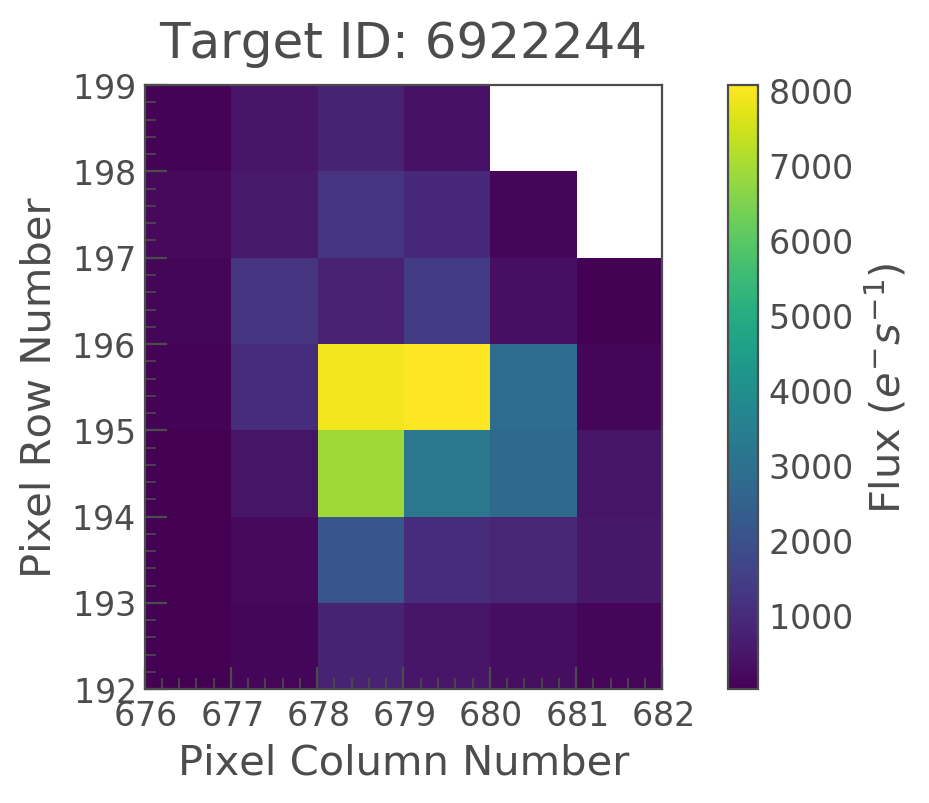

In [ ]:
tpf = lk.search_targetpixelfile('Kepler-8', quarter=10).download()
tpf.plot();

* Light Curve Files (LCFs): These files are created by the Kepler pipeline. The pipeline converts TPFs in to light curves, and stores them as a fits file. For TESS, Kepler and K2 there are two light curves in each light curve file; a Simple Aperture Photometry (SAP) light curve and a Pre Datasearch Conditioned (PDCSAP) light curve. The PDCSAP light curves have been processed to remove some instrumental artefacts.

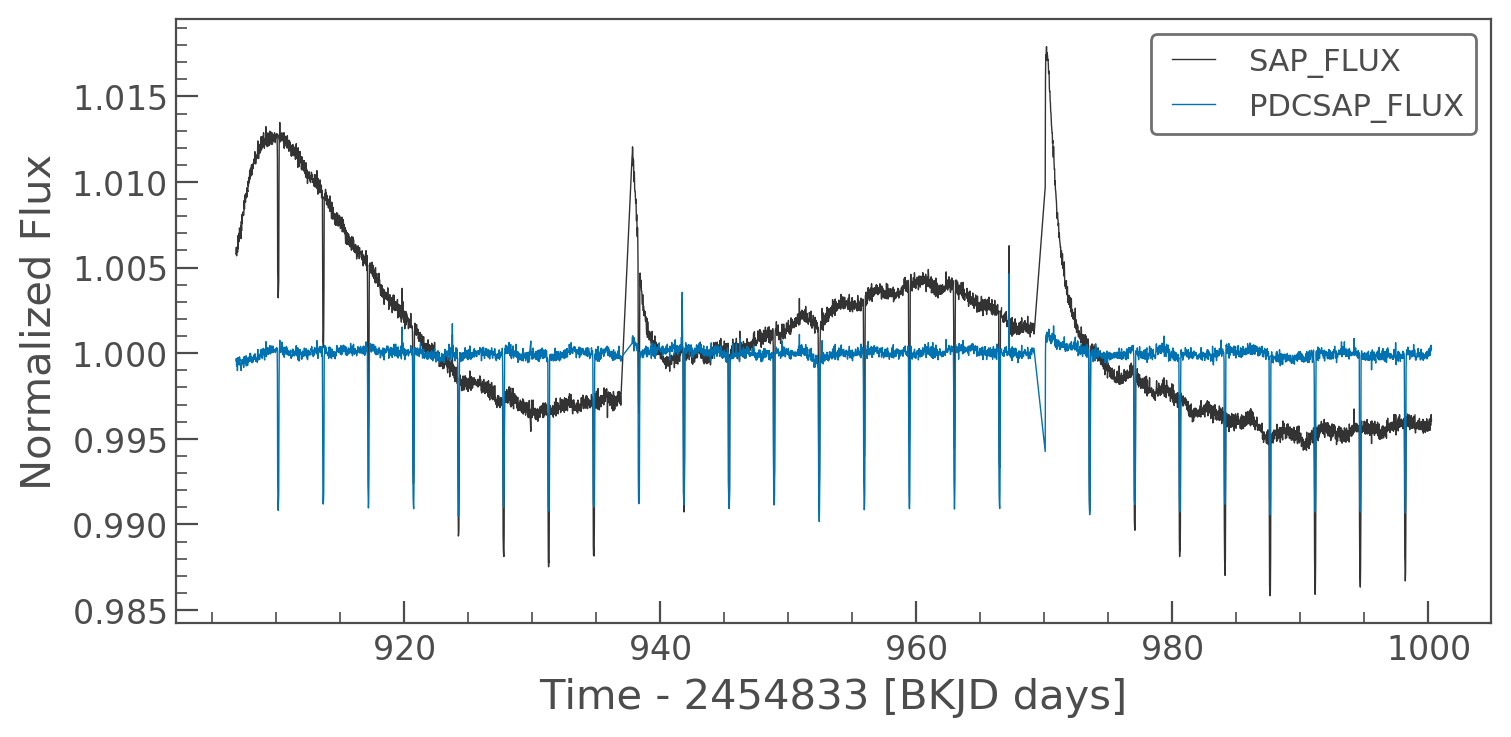

In [ ]:
lcf = lk.search_lightcurvefile('Kepler-8', quarter=10).download()
lcf.plot();

* Light Curves: Light curves are simply target flux as a function of time. Each light curve file (LCF) has two light curves in it. Light curves can also be built out of any time/flux data you have access to.

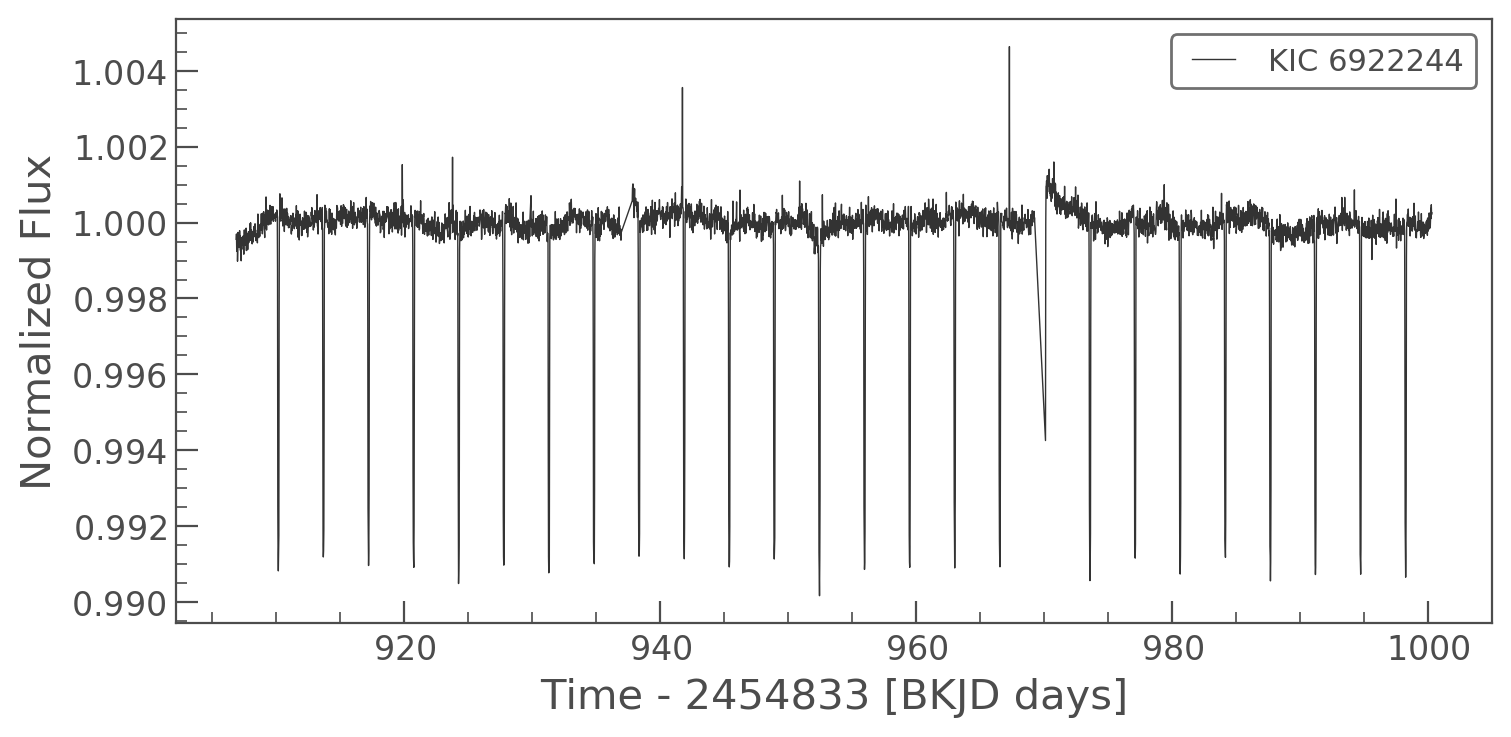

In [ ]:
lc = lcf.PDCSAP_FLUX
lc.plot();

## 3. Lightkurve workflow
The primary workflow for TESS and Kepler is to go from either TPFs or LCFs to light curves, clean and process the data, and then search for signals from e.g. transiting planets.

## 3.1 Working with a TPF

The most interesting data in a `KeplerTargetPixelFile` object are the `flux` and `time` values which give access to the brightness of the observed target over time. You can access the timestamps of the observations using the `time` property:

In [ ]:
tpf.time

array([ 906.84644936,  906.86688347,  906.88731747, ..., 1000.22714187,
       1000.24757474, 1000.26800751])

By default, `time` is in the Kepler-specific *Barycentric Kepler Julian Day* format (BKJD). You can easily convert this into [AstroPy Time objects](http://docs.astropy.org/en/stable/time/) using the `astropy_time` property:

In [ ]:
tpf.astropy_time

<Time object: scale='tdb' format='jd' value=[2455739.84644936 2455739.86688347 2455739.88731747 ... 2455833.22714187
 2455833.24757474 2455833.26800751]>

Next, let's look at the actual image data, which is available via the `flux` property:

In [ ]:
tpf.flux.shape

(4447, 7, 6)

The `flux` data is a 18104 x 21 x 11 array in units electrons/second. The first axis is the time axis, and the images themselves are 21 pixels by 11 pixels. You can use the `plot` method on the `KeplerTargetPixelFile` object to view the data.

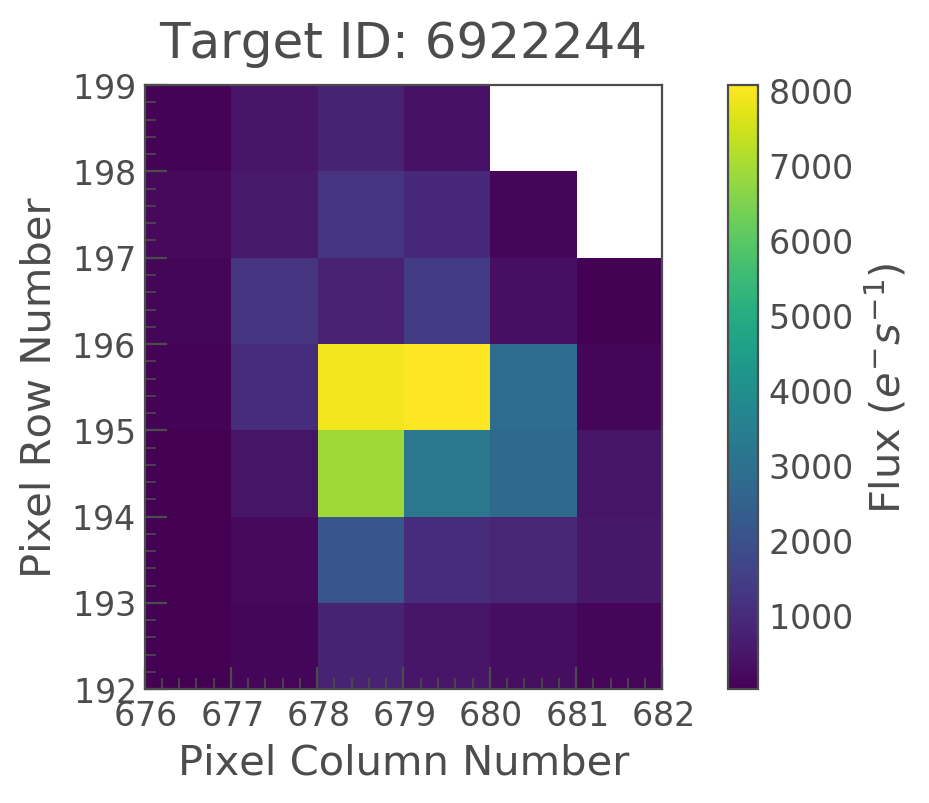

In [ ]:
tpf.plot();

You also have acces to the pipeline generated pixel mask. This mask can be used to generate a light curve, or you can create your own.

In [ ]:
tpf.pipeline_mask

array([[False, False, False, False, False, False],
       [False, False,  True,  True,  True, False],
       [False, False,  True,  True,  True, False],
       [False, False,  True,  True,  True, False],
       [False, False,  True,  True, False, False],
       [False, False,  True, False, False, False],
       [False, False, False, False, False, False]])

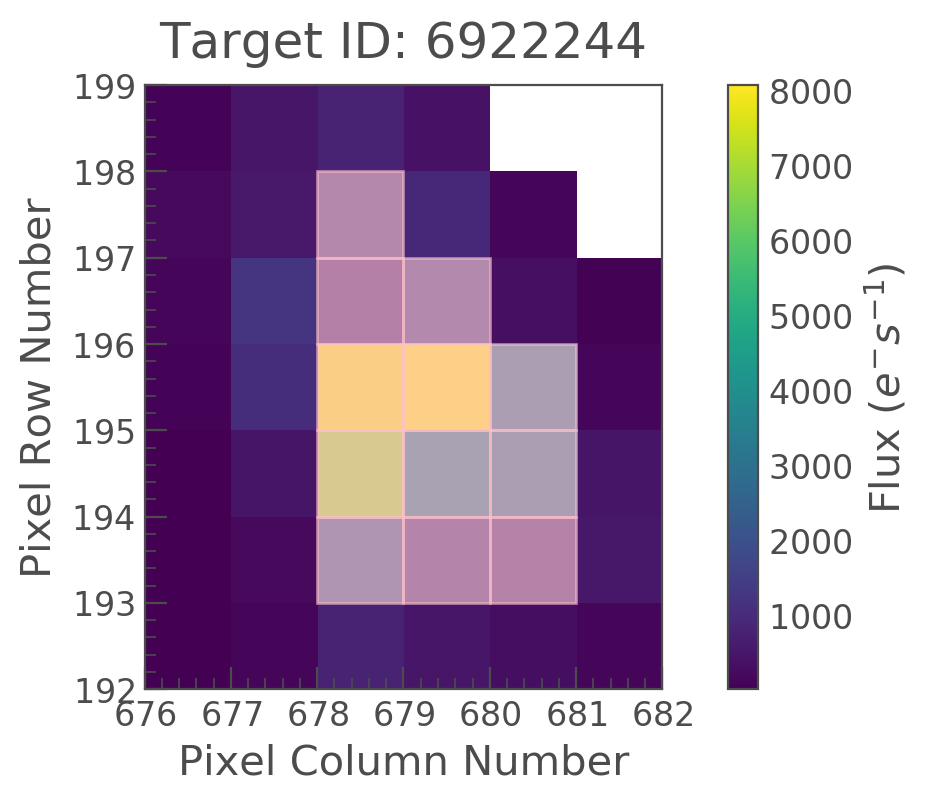

In [ ]:
tpf.plot(aperture_mask=tpf.pipeline_mask)

The `create_threshold_mask` method will allow you to build your own aperture. You can choose a `sigma` level above the background, and light curve will automatically select a target above that threshold.

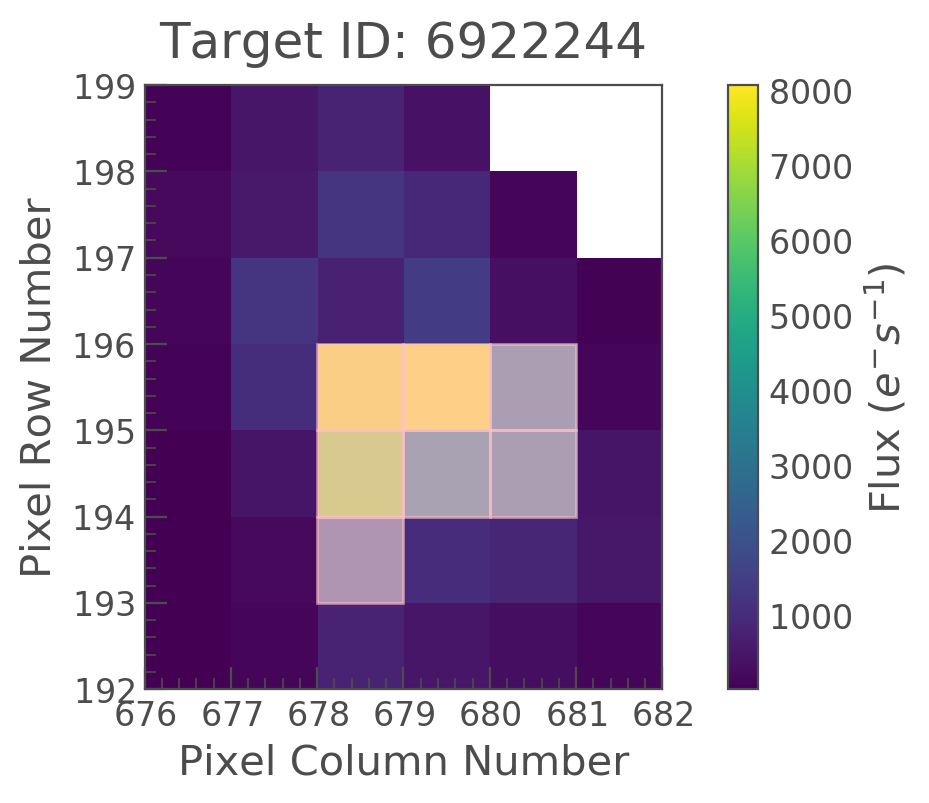

In [ ]:
aper = tpf.create_threshold_mask(threshold=2)
tpf.plot(aperture_mask=aper)

Now that we have an aperture, we can sum up the flux inside the aperture and create a light curve.

In [ ]:
lc = tpf.to_lightcurve(aperture_mask=aper)

## 3.2 Working with Light Curves

In [ ]:
lc

KeplerLightCurve(ID: 6922244)

`lc` is now a `TessLightCurve`, which has new properties and methods. For example, light curves also have a `plot` method:


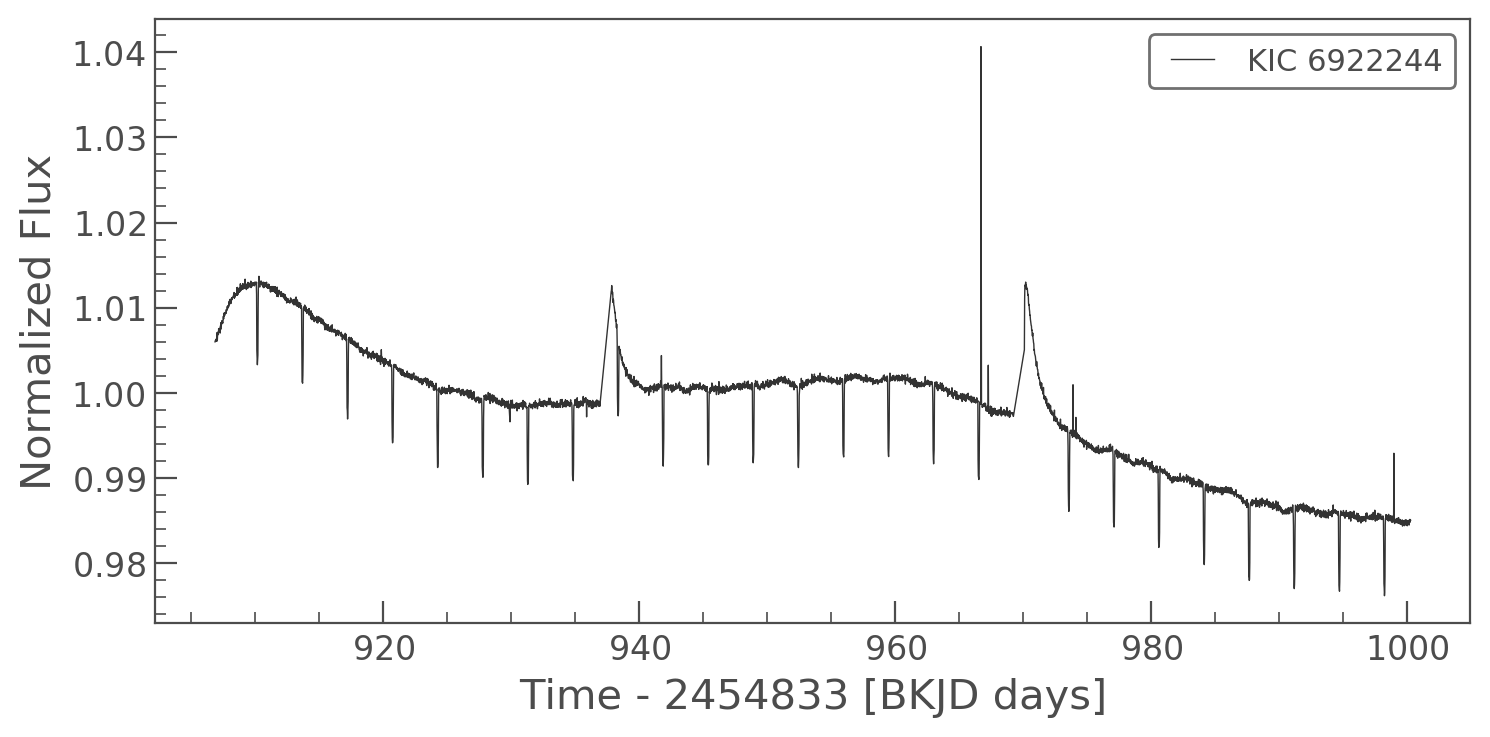

In [ ]:
lc.plot()

You can interact with this object using familiar `matplotlib.pyplot` keywords and syntax. There are also `scatter` and `errorbar` plotting methods.

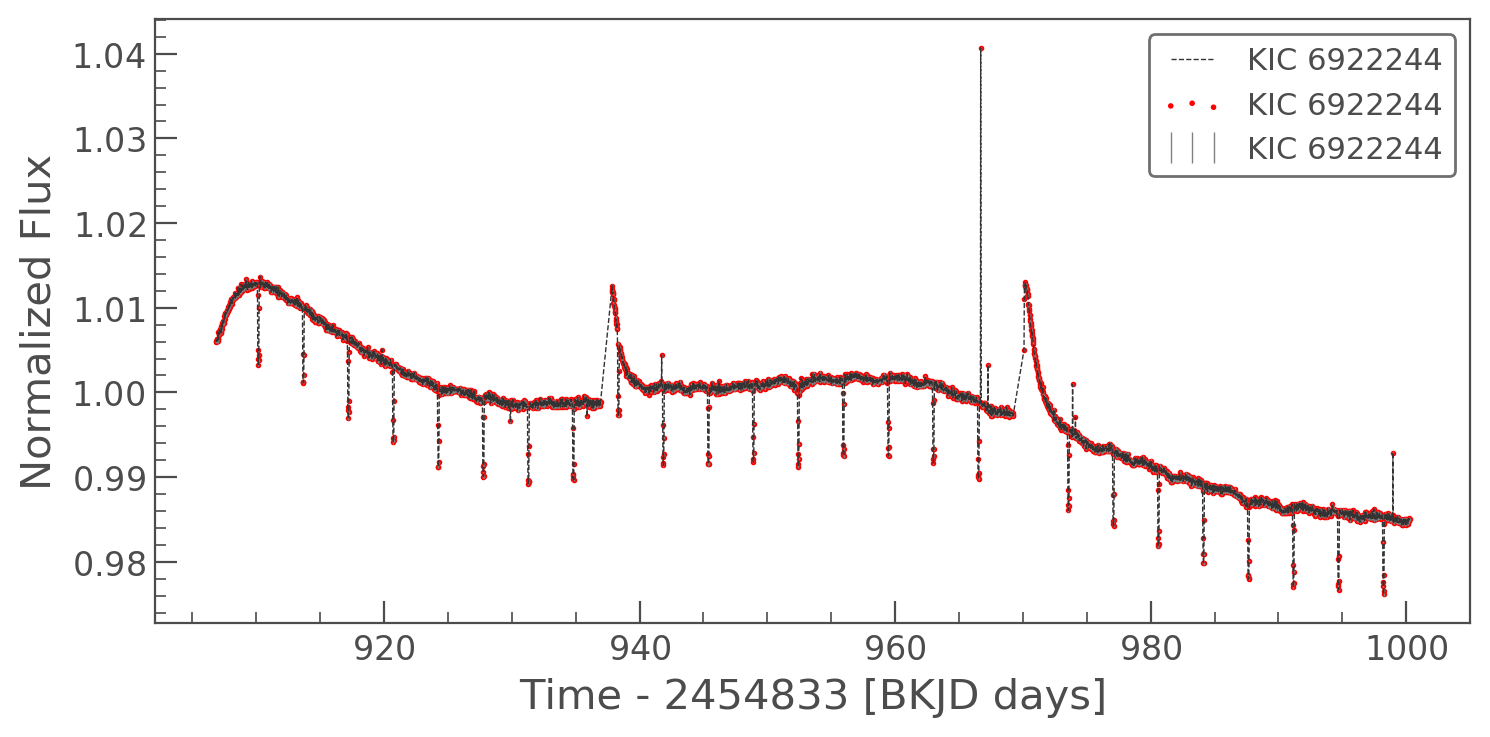

In [ ]:
ax = lc.plot(ls='--')
lc.errorbar(ax=ax, c='grey')
lc.scatter(ax=ax, c='r')

You can also use the `interact` method to interactively view the pixel data

In [ ]:
tpf.interact('http://localhost:8987') # This will fail if running from google collab, but will work if you run locally!

**Remember:** You can access the pipeline corrected light curves using light curve files from MAST. These have been corrected for instrument systematics.

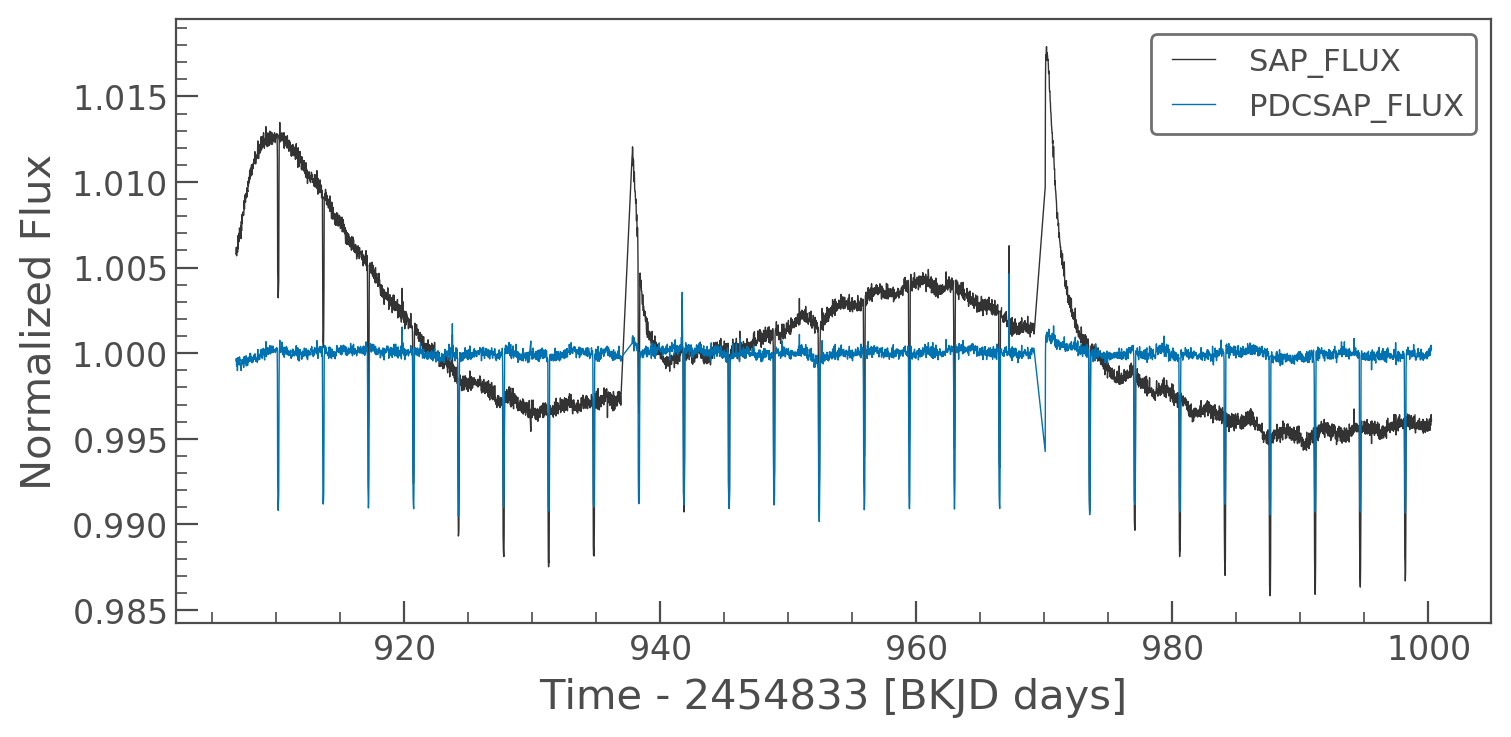

In [ ]:
lcf.plot()

In [ ]:
lcf.PDCSAP_FLUX

KeplerLightCurve(ID: 6922244)

## 4. Making simple corrections to light curves

Light curves can be corrected with the following methods:

 * `lc.remove_nans()`
 * `lc.remove_outliers()`
 * `lc.normalize()`
 * `lc.flatten()`
 * `lc.bin()`

**Remember:** You can read more about each method in the docs, or in our docstrings.

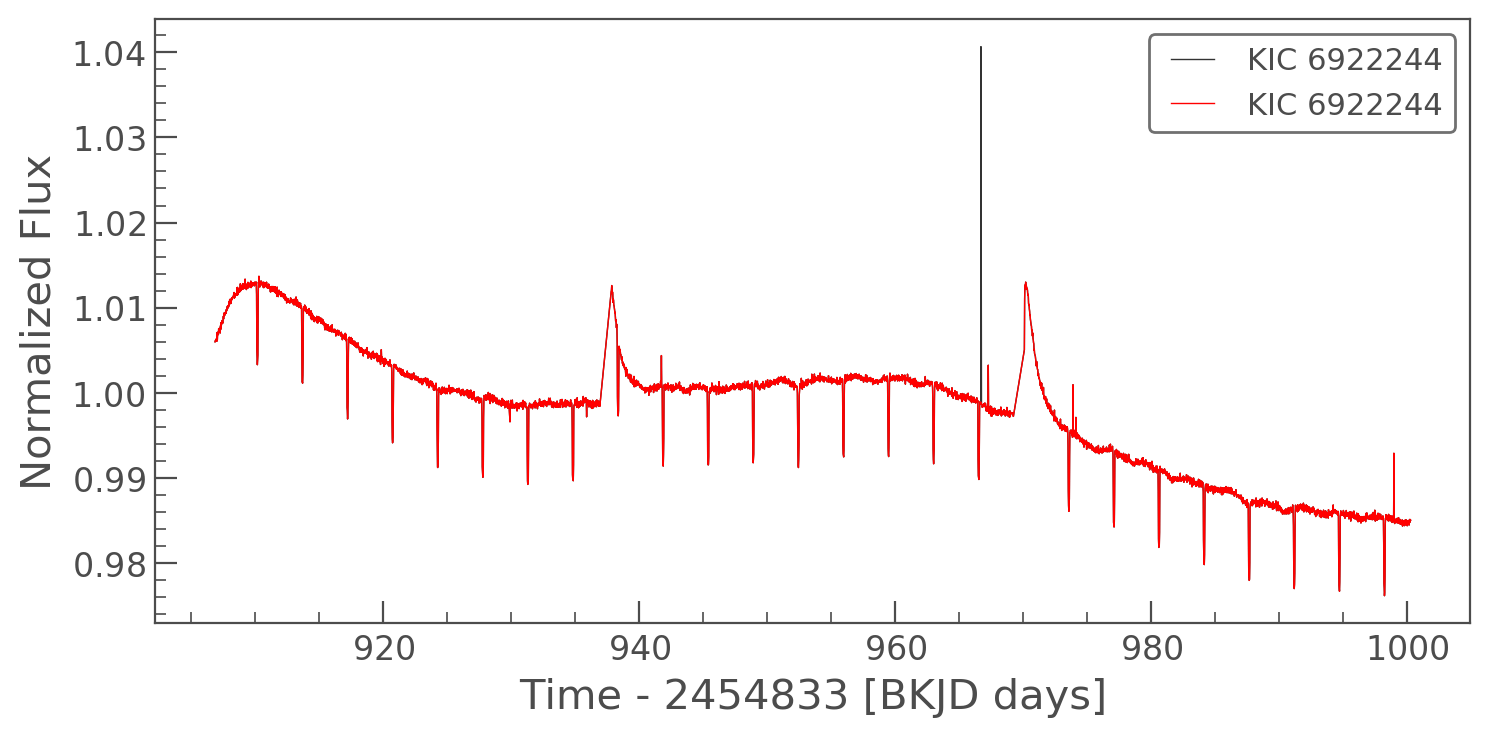

In [ ]:
ax = lc.plot()
lc.remove_outliers(sigma=5).plot(ax=ax, c='red');

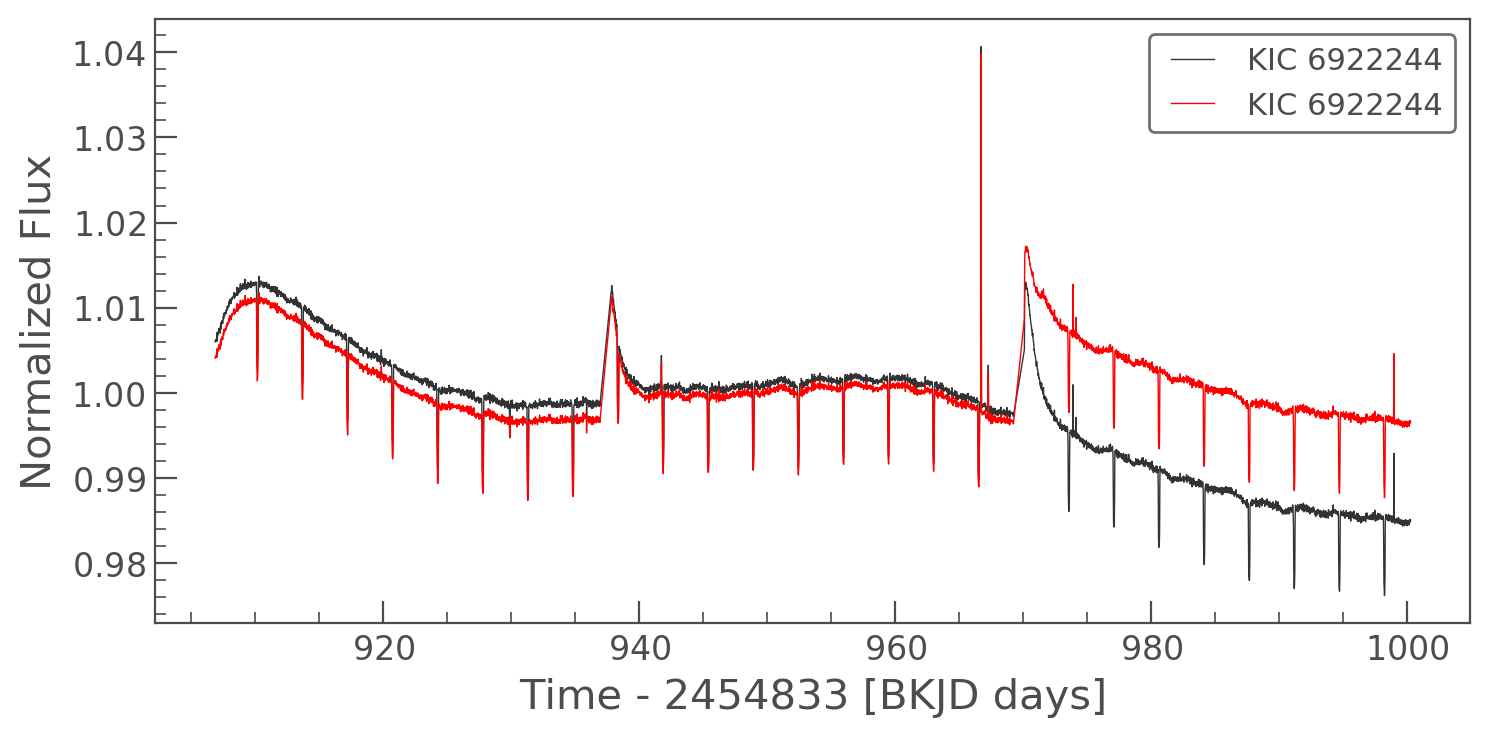

In [ ]:
ax = lc.plot()
lc.flatten(window_length=1501, break_tolerance=50).plot(ax=ax, c='red');

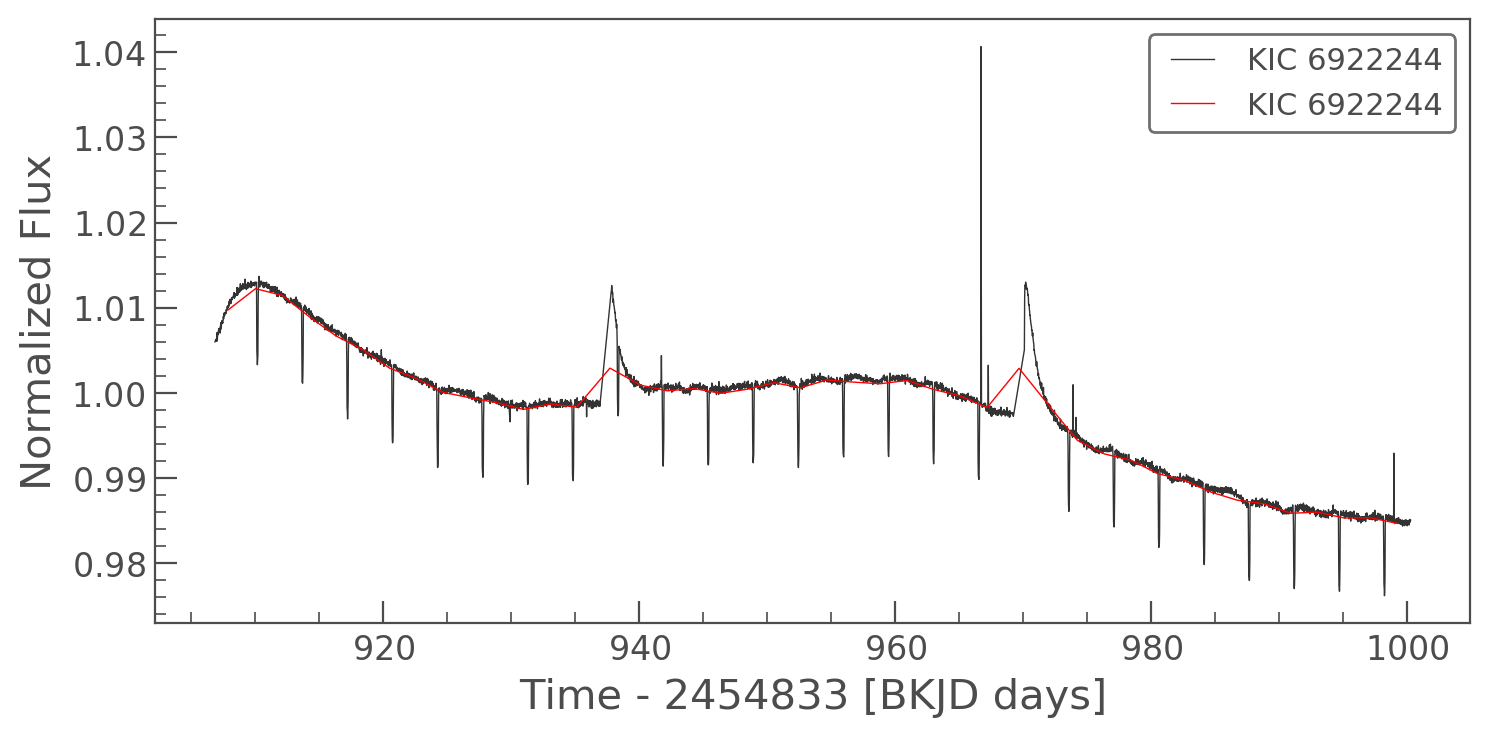

In [ ]:
ax = lc.plot()
lc.bin(binsize=100).plot(ax=ax, c='red');

## 4.1 Folding Light Curves

When looking for periodic signals, it's useful to be able to fold a light curve at a period and midpoint. Light curve lets you do this with the `fold` method on light curves.

In [ ]:
period = 3.5224991
t0 = 2454954.11931 - 2454833 # Convert to BKJD

For now, let's take the the PDCSAP_FLUX from the Kepler Pipeline version of the data, as this has had most of the Kepler systematics removed for us.

In [ ]:
lc = lcf.PDCSAP_FLUX
folded_lc = lc.fold(period, t0)
folded_lc

`FoldedLightCurve` is a class similar to `LightCurve`, but it has the `phase` attribute.

In [ ]:
folded_lc.phase

array([-0.49971689, -0.49955294, -0.49943681, ...,  0.49955081,
        0.49974787,  0.49994605])

This time has been folded at the period given, and centered around t0. Plotting a folded light curve will show a plot in phase.

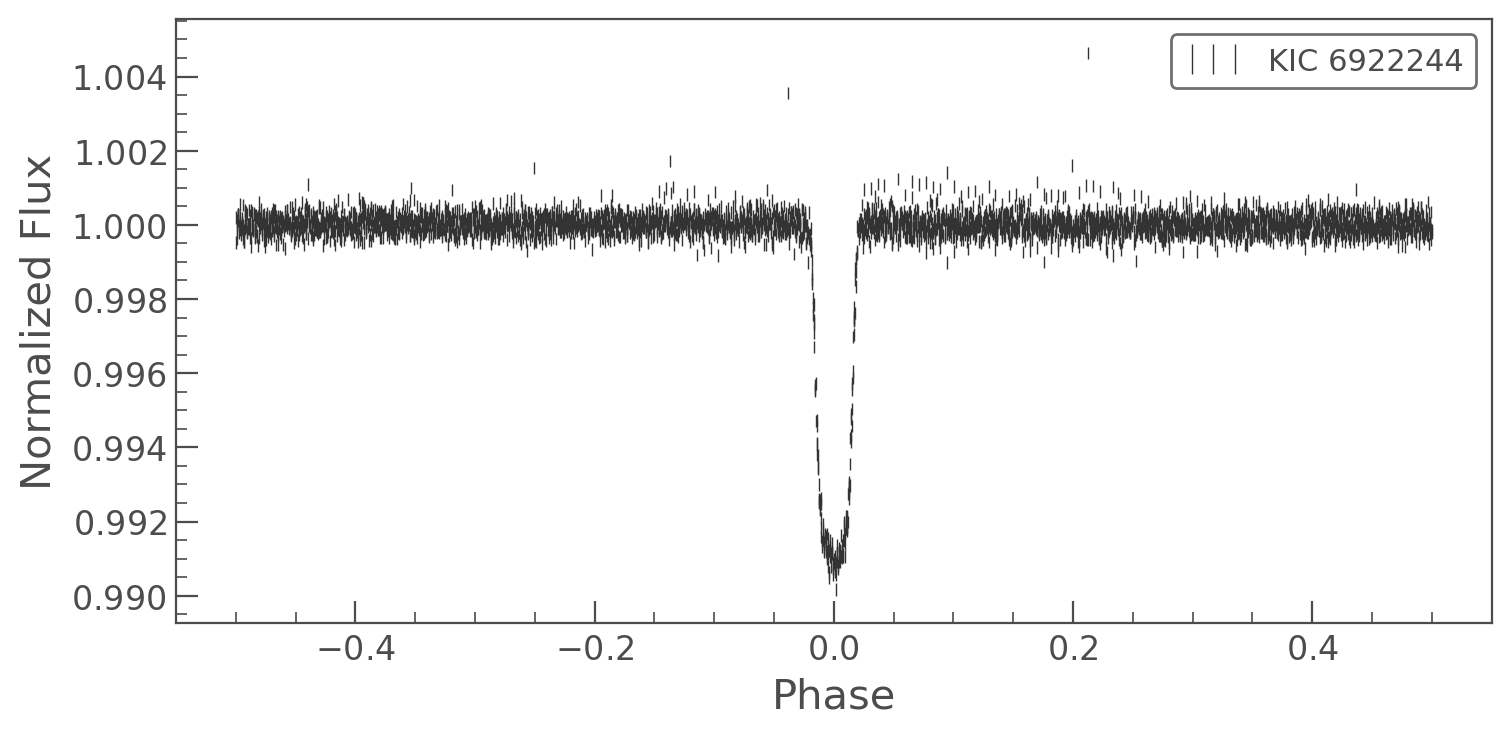

In [ ]:
folded_lc.errorbar()

We see here there is a transit in the center!

## 4.2 Stringing Commands Together

Using light curve it is possible to string these commands together in a single "sentence".

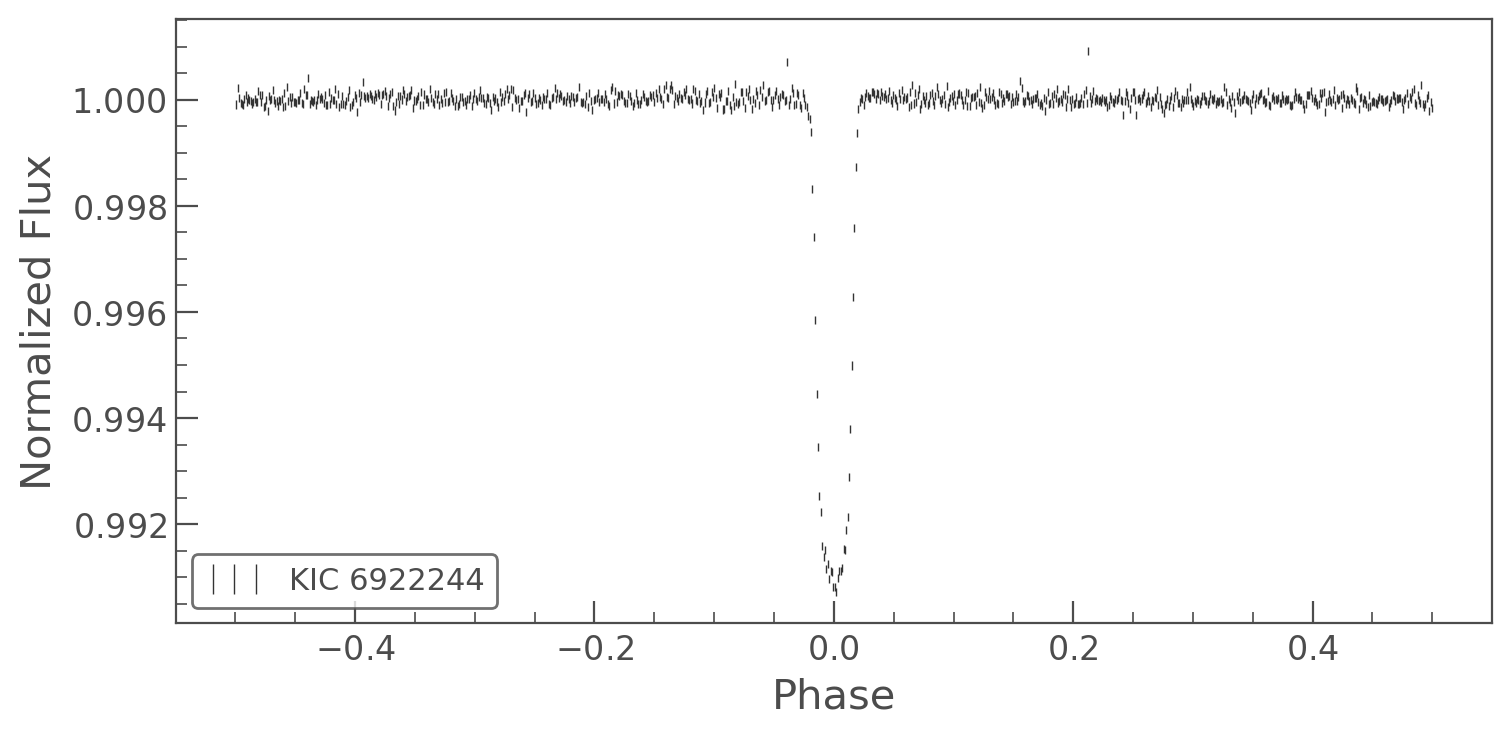

In [ ]:
lc = lcf.PDCSAP_FLUX.remove_nans().flatten(window_length=501, break_tolerance=50).remove_outliers(sigma_upper=4, sigma_lower=10)
lc.fold(period, t0).bin(5).errorbar()

## 5. Converting light curves to other formats

When you have created a light curve you may want to share it with collaborators, or submit your light curves as High Level Science Products to the MAST archive. Lightkurve lets you do this by converting light curves to files. The following methods allow easy file sharing:

* `lc.to_pandas()`
* `lc.to_fits(PATH)`
* `lc.to_csv(PATH)`

In [ ]:
lc.to_pandas().head(5)

,time,flux,flux_err,quality,centroid_col,centroid_row
time,,,,,,
906.866883,906.866883,0.999995,0.000169,0,678.630217,194.717900
906.887317,906.887317,1.000131,0.000169,0,678.630329,194.718354
906.907752,906.907752,0.999673,0.000169,0,678.630234,194.718658
906.928185,906.928185,0.999788,0.000169,0,678.629639,194.719218
906.948619,906.948619,1.000075,0.000169,0,678.629691,194.718845


In [ ]:
lc.to_fits('output.fits', overwrite=True)

In [ ]:
lc.to_fits('output.fits', overwrite=True)

In [ ]:
% ls -lh output.fits

-rw-r--r--  1 ch  staff   129K Mar  6 10:06 output.fits


## 6. Searching for Targets

Now we know how to work with the data, let's revisit how you can find data on MAST using light curve. We have two main search functions

* `search_targetpixelfile`
* `search_lightcurvefile`

These will allow you to find targets on MAST using either

* KIC/EPIC/TIC ID
* RA/Dec
* astropy.SkyCoord object
* Target name

In [ ]:
search_result = lk.search_lightcurvefile('Kepler-10')

In [ ]:
search_result

SearchResult containing 15 data products.

 target_name            productFilename                        description             distance
------------- ------------------------------------ ----------------------------------- --------
kplr011904151 kplr011904151-2009131105131_llc.fits  Lightcurve Long Cadence (CLC) - Q0      0.0
kplr011904151 kplr011904151-2009166043257_llc.fits  Lightcurve Long Cadence (CLC) - Q1      0.0
kplr011904151 kplr011904151-2009259160929_llc.fits  Lightcurve Long Cadence (CLC) - Q2      0.0
kplr011904151 kplr011904151-2009350155506_llc.fits  Lightcurve Long Cadence (CLC) - Q3      0.0
kplr011904151 kplr011904151-2010009091648_llc.fits  Lightcurve Long Cadence (CLC) - Q4      0.0
kplr011904151 kplr011904151-2010174085026_llc.fits  Lightcurve Long Cadence (CLC) - Q5      0.0
kplr011904151 kplr011904151-2010265121752_llc.fits  Lightcurve Long Cadence (CLC) - Q6      0.0
kplr011904151 kplr011904151-2010355172524_llc.fits  Lightcurve Long Cadence (CLC) - Q7      0

This has returned a `SearchResult` object, which has a list of all the products available on MAST. Here we see there are several long cadence light curves available, one for each quarter. You can cut down this list by specifying keywords.

In [ ]:
search_result = lk.search_lightcurvefile('Kepler-10', quarter=3)

In [ ]:
search_result

SearchResult containing 1 data products.

 target_name            productFilename                       description             distance
------------- ------------------------------------ ---------------------------------- --------
kplr011904151 kplr011904151-2009350155506_llc.fits Lightcurve Long Cadence (CLC) - Q3      0.0

Alternately, you can index into the search result

In [ ]:
search_result = lk.search_lightcurvefile('Kepler-10')
search_result[3]

SearchResult containing 1 data products.

 target_name            productFilename                       description             distance
------------- ------------------------------------ ---------------------------------- --------
kplr011904151 kplr011904151-2009350155506_llc.fits Lightcurve Long Cadence (CLC) - Q3      0.0

Once you have a search result and you would like to download it, simply add the `download()` method.

In [ ]:
lcf = search_result[3].download()

In [ ]:
lcf

KeplerLightCurveFile(ID: 11904151)

This has now returned a Light Curve File, which we can use in the same way as above. Below are some examples of how to search for data

In [ ]:
lcf = lk.search_lightcurvefile('026.0170142608, -15.9374795978').download()

In [ ]:
from astropy.coordinates import SkyCoord
import astropy.units as u
c = SkyCoord(026.0170142608, -15.9374795978, unit=(u.deg, u.deg))
lcf = lk.search_lightcurvefile(c).download()

In [ ]:
tpf = lk.search_targetpixelfile('KIC 8462852', quarter=10).download()

You can also use the `download_all` method, to download the full manifest of a search. This will return a `LightCurveFileCollection` object, which is a group of light curves.

In [ ]:
lcfs = lk.search_lightcurvefile('Kepler-10').download_all()
lcfs

LightCurveFileCollection of 15 objects:
KeplerLightCurveFile(ID: 11904151) 
KeplerLightCurveFile(ID: 11904151) 
KeplerLightCurveFile(ID: 11904151) 
KeplerLightCurveFile(ID: 11904151) 
KeplerLightCurveFile(ID: 11904151) 
KeplerLightCurveFile(ID: 11904151) 
KeplerLightCurveFile(ID: 11904151) 
KeplerLightCurveFile(ID: 11904151) 
KeplerLightCurveFile(ID: 11904151) 
KeplerLightCurveFile(ID: 11904151) 
KeplerLightCurveFile(ID: 11904151) 
KeplerLightCurveFile(ID: 11904151) 
KeplerLightCurveFile(ID: 11904151) 
KeplerLightCurveFile(ID: 11904151) 
KeplerLightCurveFile(ID: 11904151) 

### 6.1 Radius Queries

Using the `search_...` functions, it is possible to do a radius query, and find targets that are nearby to your target of interest. This is particularly useful when trying to assess systematics in your target.

In [ ]:
# Find the nearest three targets within 100 arcseconds
search_result = lk.search_lightcurvefile('Kepler-10', quarter=3, radius=100, limit=3)

In [ ]:
search_result

SearchResult containing 3 data products.

 target_name            productFilename                       description                  distance    
------------- ------------------------------------ ---------------------------------- -----------------
kplr011904151 kplr011904151-2009350155506_llc.fits Lightcurve Long Cadence (CLC) - Q3               0.0
kplr011904148 kplr011904148-2009350155506_llc.fits Lightcurve Long Cadence (CLC) - Q3 55.73614039441601
kplr011904099 kplr011904099-2009350155506_llc.fits Lightcurve Long Cadence (CLC) - Q3 69.04910898467242

In [ ]:
lcfs = search_result.download_all()
lcfs

LightCurveFileCollection of 3 objects:
KeplerLightCurveFile(ID: 11904151) 
KeplerLightCurveFile(ID: 11904148) 
KeplerLightCurveFile(ID: 11904099) 

### 6.2 Obtaining TESS FFI Cut outs

New in lightkurve you can now search for TESS cut outs in the FFIs. This feature uses the TESSCut tool from MAST.

In [ ]:
lk.search_tesscut('026.0170142608, -15.9374795978')

SearchResult containing 1 data products.

         target_name           productFilename        description         distance
------------------------------ --------------- -------------------------- --------
026.0170142608, -15.9374795978             n/a TESS FFI Cutout (sector 3)      0.0

In [ ]:
tpf = lk.search_tesscut('Pi Men').download(cutout_size=20)

/Users/ch/K2/repos/lightkurve/lightkurve/search.py:144: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


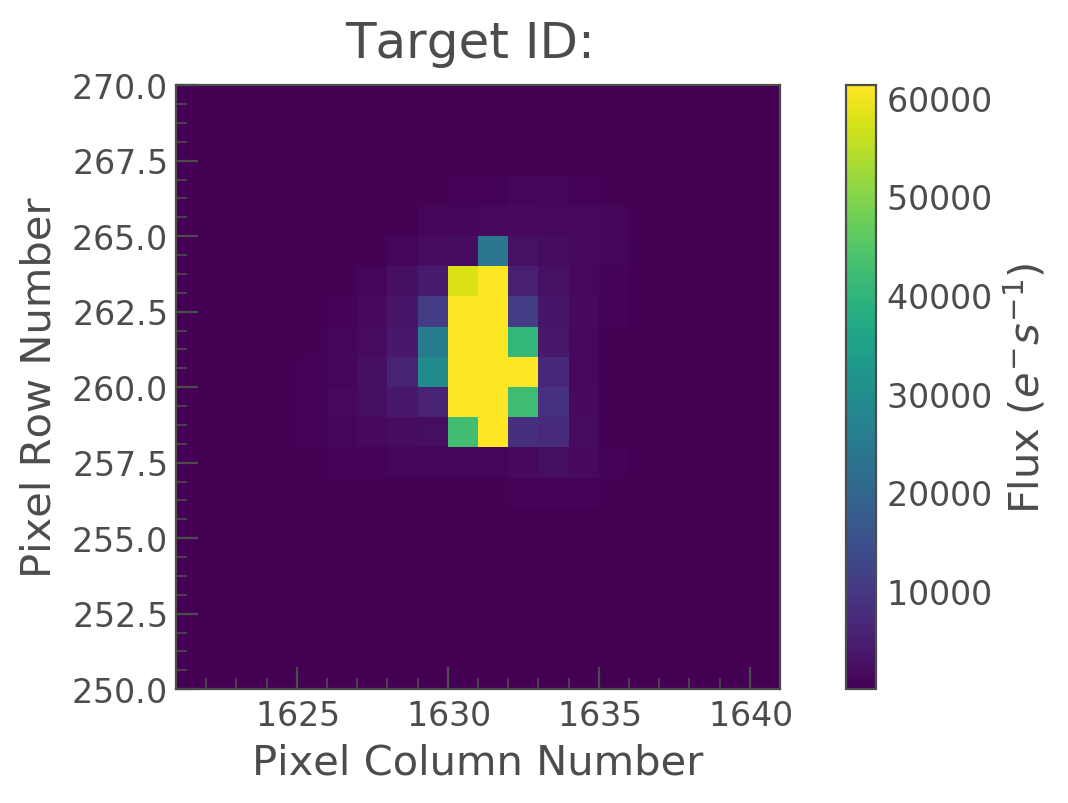

In [ ]:
tpf.plot()

**Remember**: These are not Pipeline products, these are simply cut outs of the TESS FFIs. Because of this, they do not have aperture masks. You will have to create your own! The FFIs also do not have background removed, and have many instrument systematics. Make sure you correct for these!

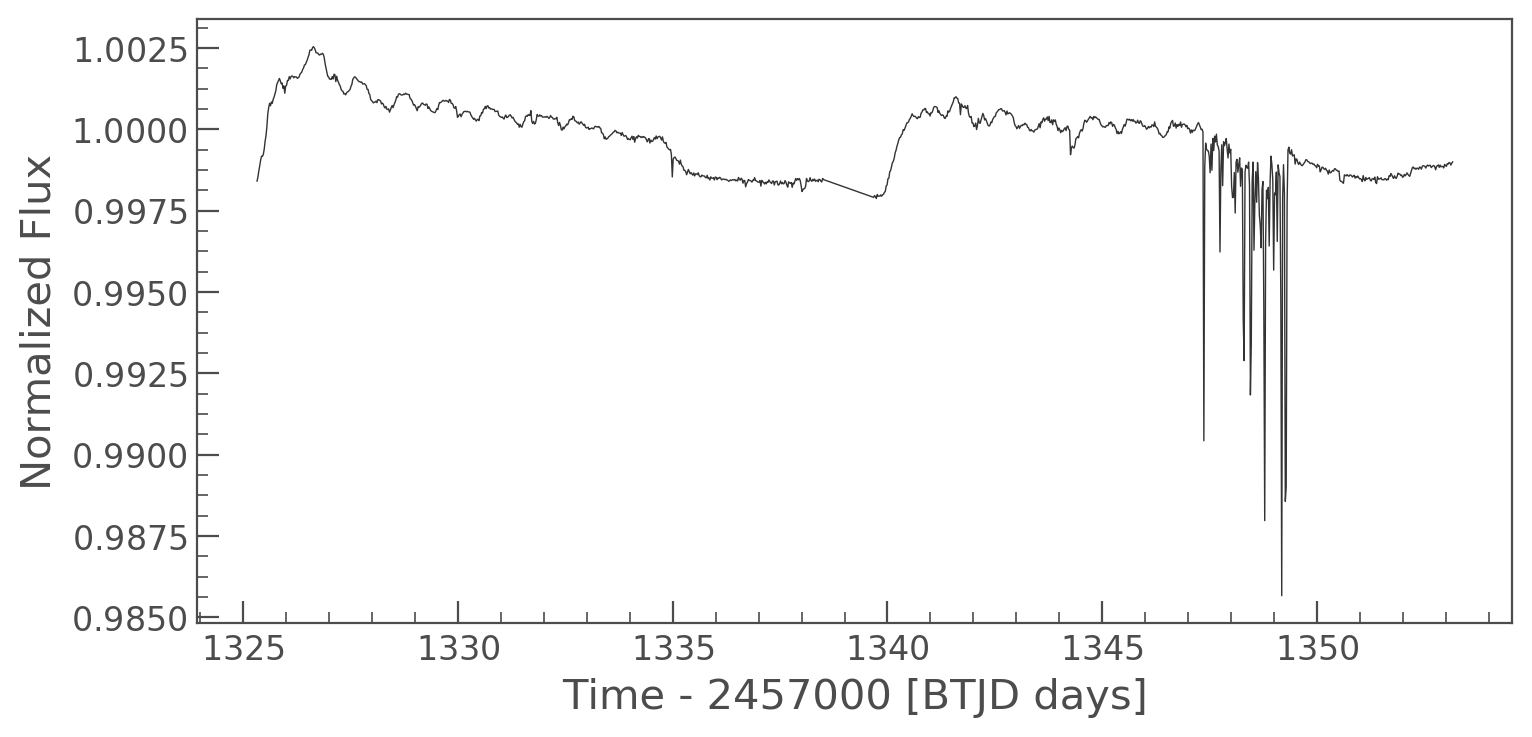

In [ ]:
aper = tpf.create_threshold_mask()
tpf.to_lightcurve(aperture_mask=aper).plot();

### 6.3 Stitching Light Curves

You can use lightkurve for Kepler data too! There are one or two helpful classes for dealing with Kepler data that are worth mentioning.

Kepler data was split into many 'quarters', each of which must be stitched together. The Continuous Viewing Zone in TESS will also have targets that will be revisited, and so some TESS targets will also require stitched together.

To do this we first use the `download_all` method on our search.

In [ ]:
lcfs = lk.search_lightcurvefile('KIC 12216817').download_all()

In [ ]:
lcfs

LightCurveFileCollection of 18 objects:
KeplerLightCurveFile(ID: 12216817) 
KeplerLightCurveFile(ID: 12216817) 
KeplerLightCurveFile(ID: 12216817) 
KeplerLightCurveFile(ID: 12216817) 
KeplerLightCurveFile(ID: 12216817) 
KeplerLightCurveFile(ID: 12216817) 
KeplerLightCurveFile(ID: 12216817) 
KeplerLightCurveFile(ID: 12216817) 
KeplerLightCurveFile(ID: 12216817) 
KeplerLightCurveFile(ID: 12216817) 
KeplerLightCurveFile(ID: 12216817) 
KeplerLightCurveFile(ID: 12216817) 
KeplerLightCurveFile(ID: 12216817) 
KeplerLightCurveFile(ID: 12216817) 
KeplerLightCurveFile(ID: 12216817) 
KeplerLightCurveFile(ID: 12216817) 
KeplerLightCurveFile(ID: 12216817) 
KeplerLightCurveFile(ID: 12216817) 

In [ ]:
# Use the normalized PDCSAP_FLUX
lc = lcfs[0].PDCSAP_FLUX.normalize()

# Loop through the rest of the LCFS, appending to the first light curve
for lcf in lcfs[1:]:
    lc = lc.append(lcf.PDCSAP_FLUX.normalize())

In [ ]:
lc

KeplerLightCurve(ID: 12216817)

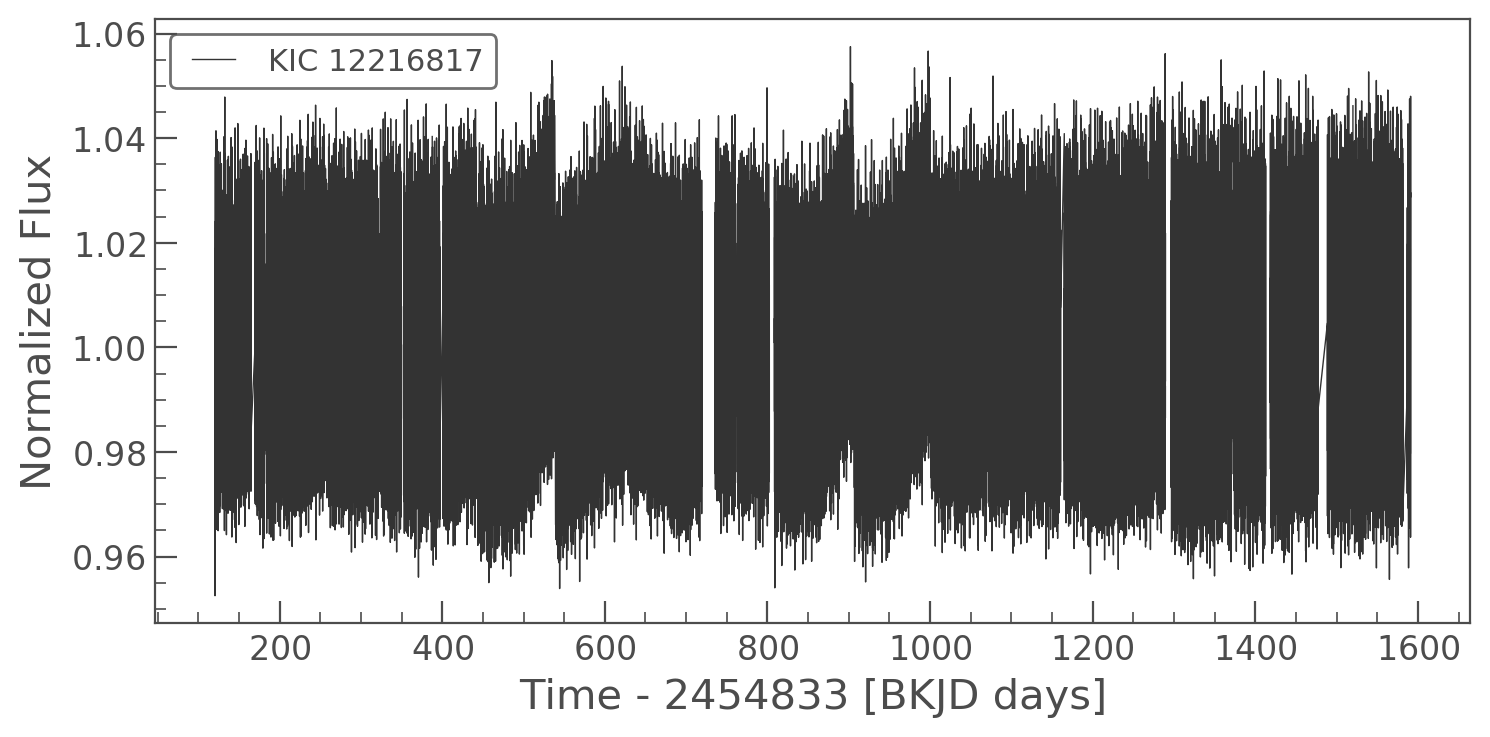

In [ ]:
lc.plot()

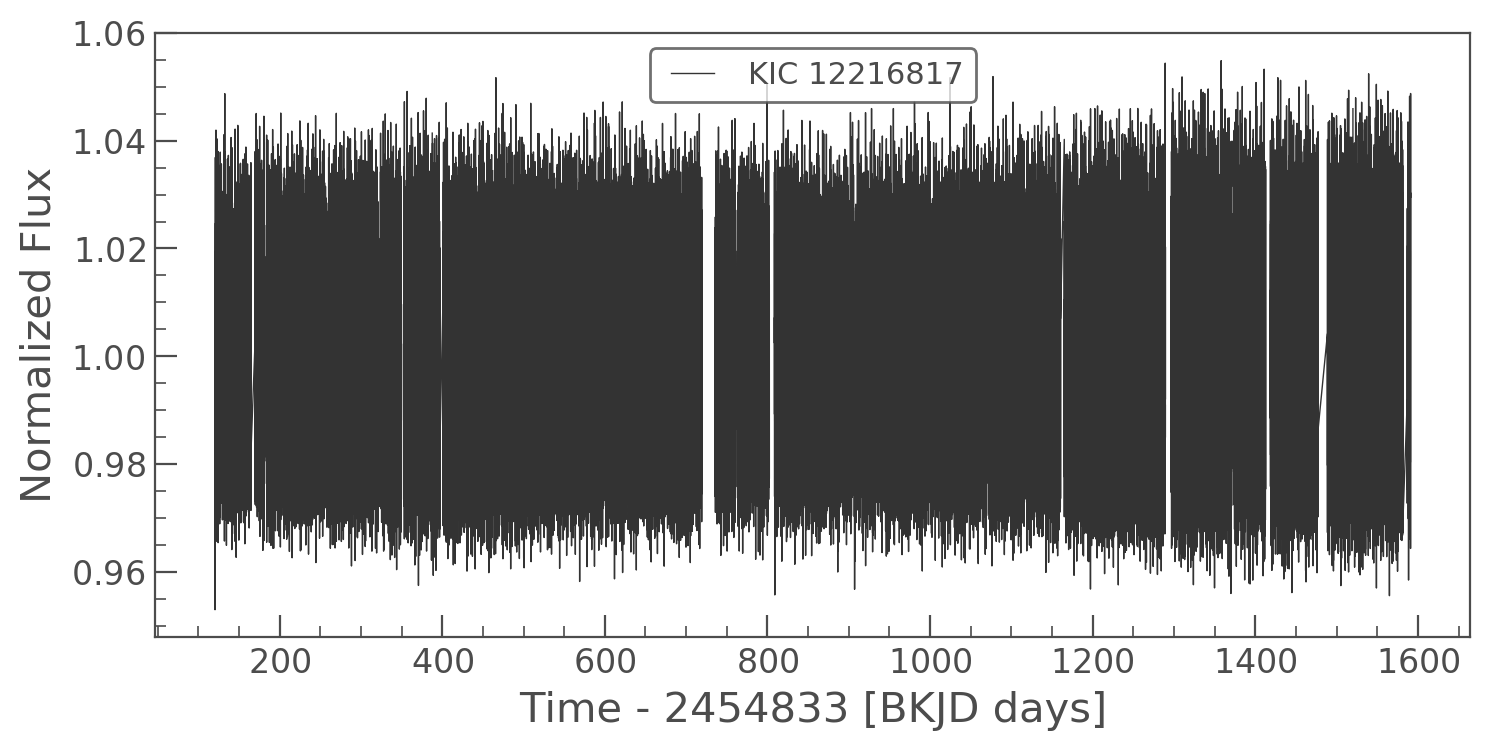

In [ ]:
lc = lc.flatten(window_length=701, break_tolerance=50)
lc.plot()

## 7. Periodograms

We often care about periodic signals when we're using Kepler and TESS data. Lightkurve has a handy built in `Periodogram` class which can help you search for periodic signals.

In [ ]:
import numpy as np
# Create periodogram object
p = lc.remove_nans().to_periodogram(method='LombScargle')

In [ ]:
p

LombScarglePeriodogram(ID: 12216817)

This has now created a `Periodogram` class object, which has many useful methods and attributes. You will mostly be using the `plot` method:

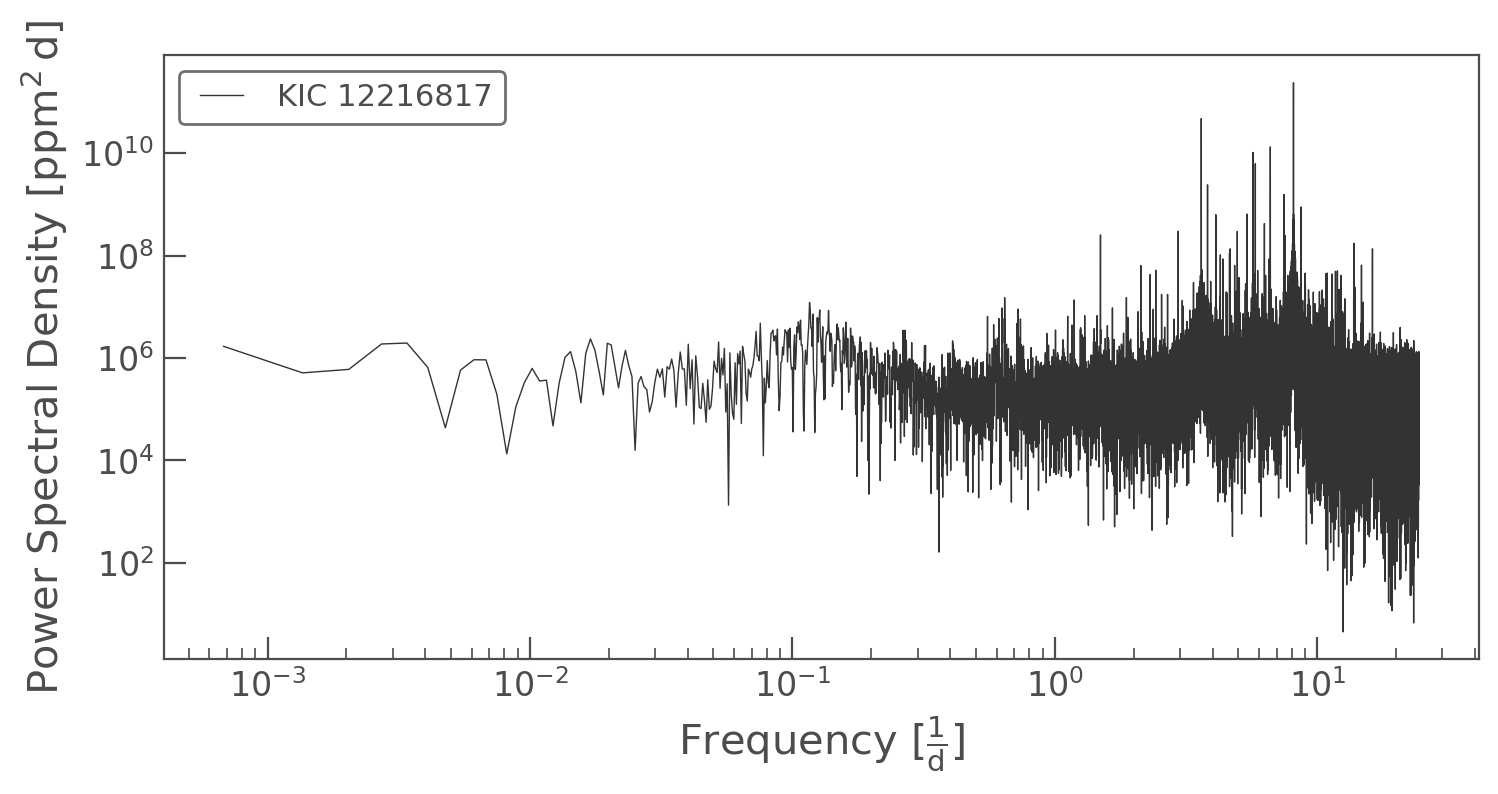

In [ ]:
p.plot(scale='log')

There is a strong periodicity in this data! The `Periodogram` object has an attribute `period_at_max_power` which stores the best period.

In [ ]:
p.period_at_max_power

<Quantity 0.12313369 d>

If we fold the light curve at this period, we find a strong periodic signal!

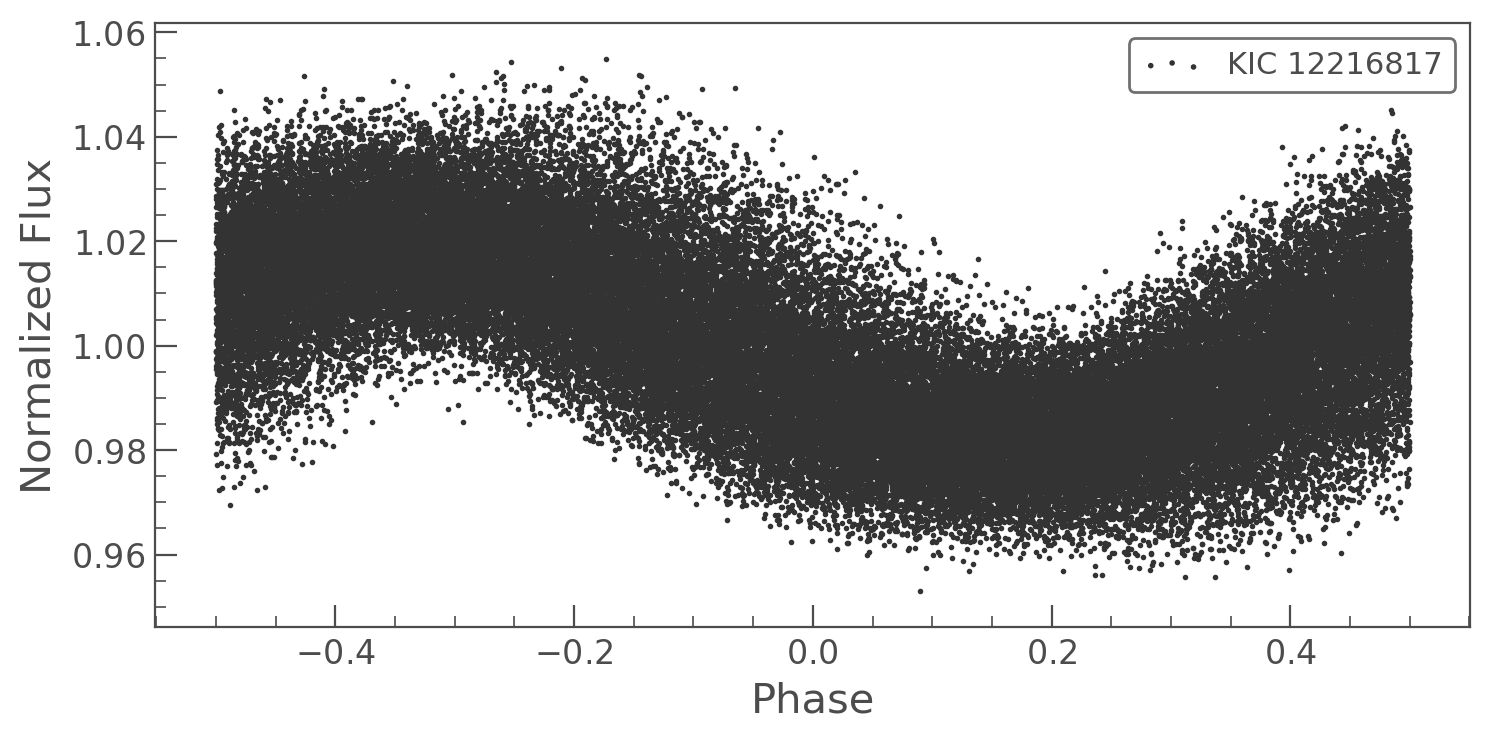

In [ ]:
lc.fold(p.period_at_max_power.value).scatter();

### 7.1 BLS Periodograms

Above we have created a Lomb Scargle periodogram, which is useful for analyzing signals that are sinusoidal. It is also possible to create a BLS periodogram, which is useful for finding transits.

**Note:** There is a full tutorial on how BLS works and how to use it available in this directory!

In [ ]:
lc = lk.search_lightcurvefile('Kepler-8', quarter=4).download().PDCSAP_FLUX

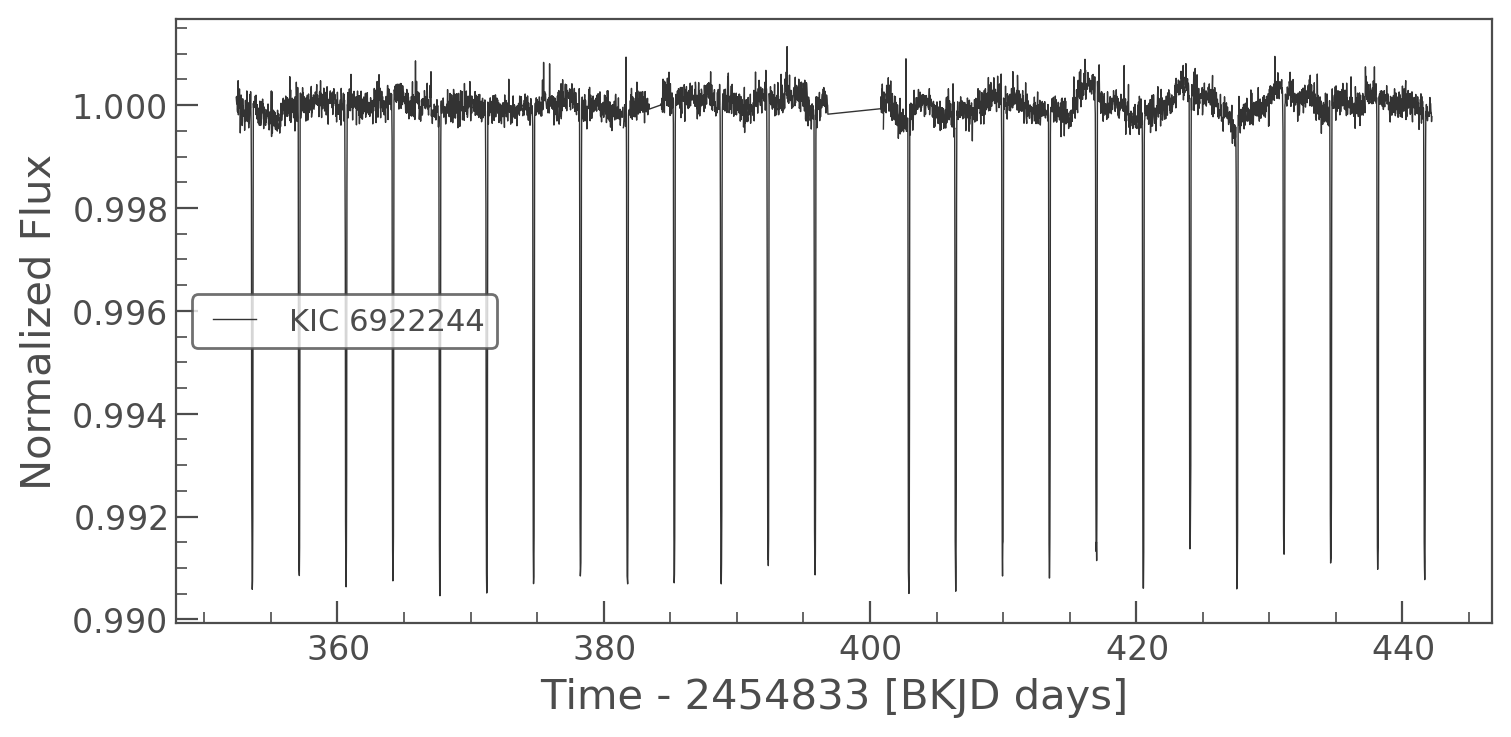

In [ ]:
lc.plot()

In [ ]:
# Note that we set the duration when we create the periodogram
p = lc.to_periodogram('bls', duration=0.1)
p

BoxLeastSquaresPeriodogram(ID: 6922244)

`p` is now a `BoxLeastSquaresPeriodogram`, which still has the plot method

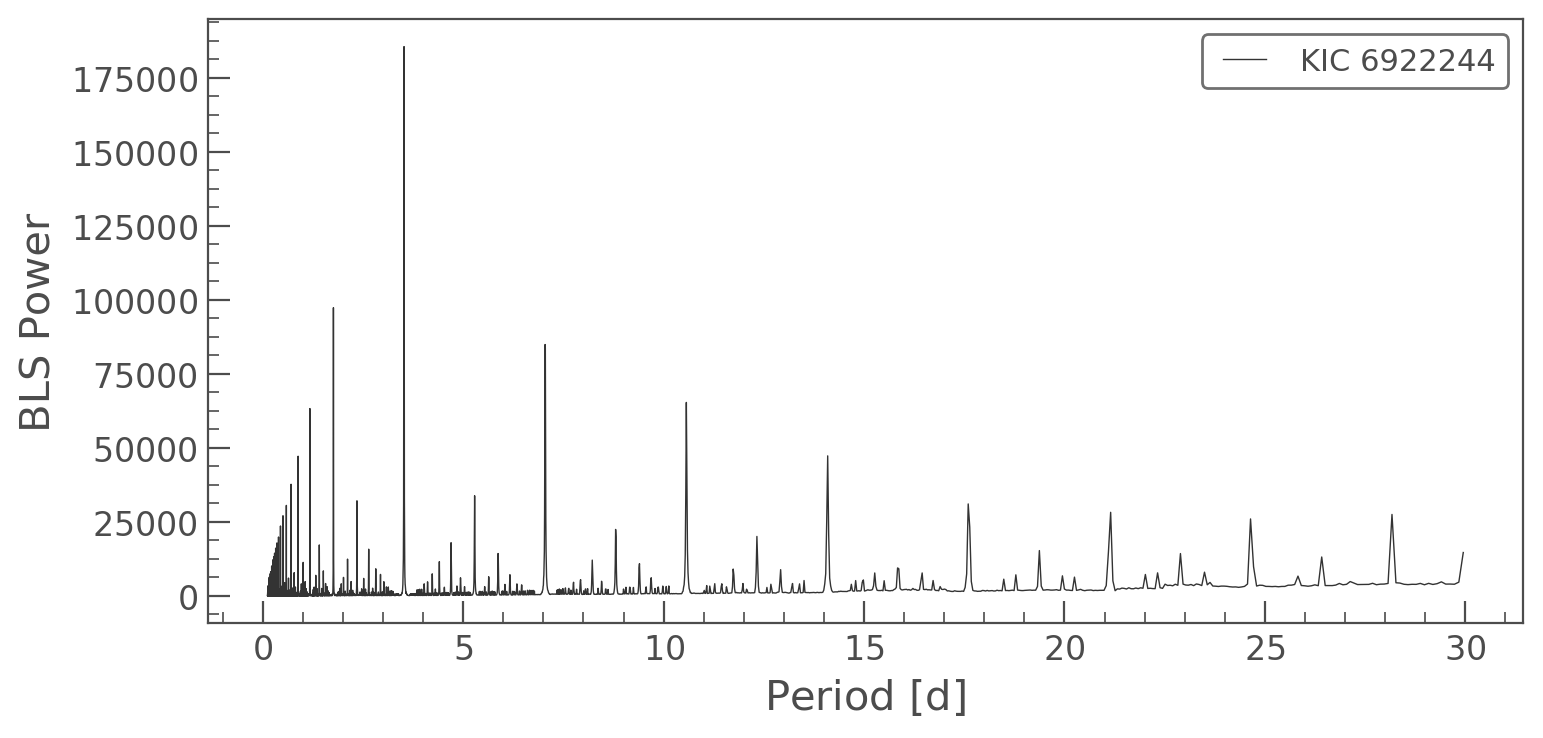

In [ ]:
p.plot()

This time we have a few more attributes
* `p.period_at_max_power`
* `p.transit_time_at_max_power`
* `p.duration_at_max_power`
* `p.depth_at_max_power`

In [ ]:
period = p.period_at_max_power.value
t0 = p.transit_time_at_max_power

We can now use these values to fold our light curve at the period of the planet.

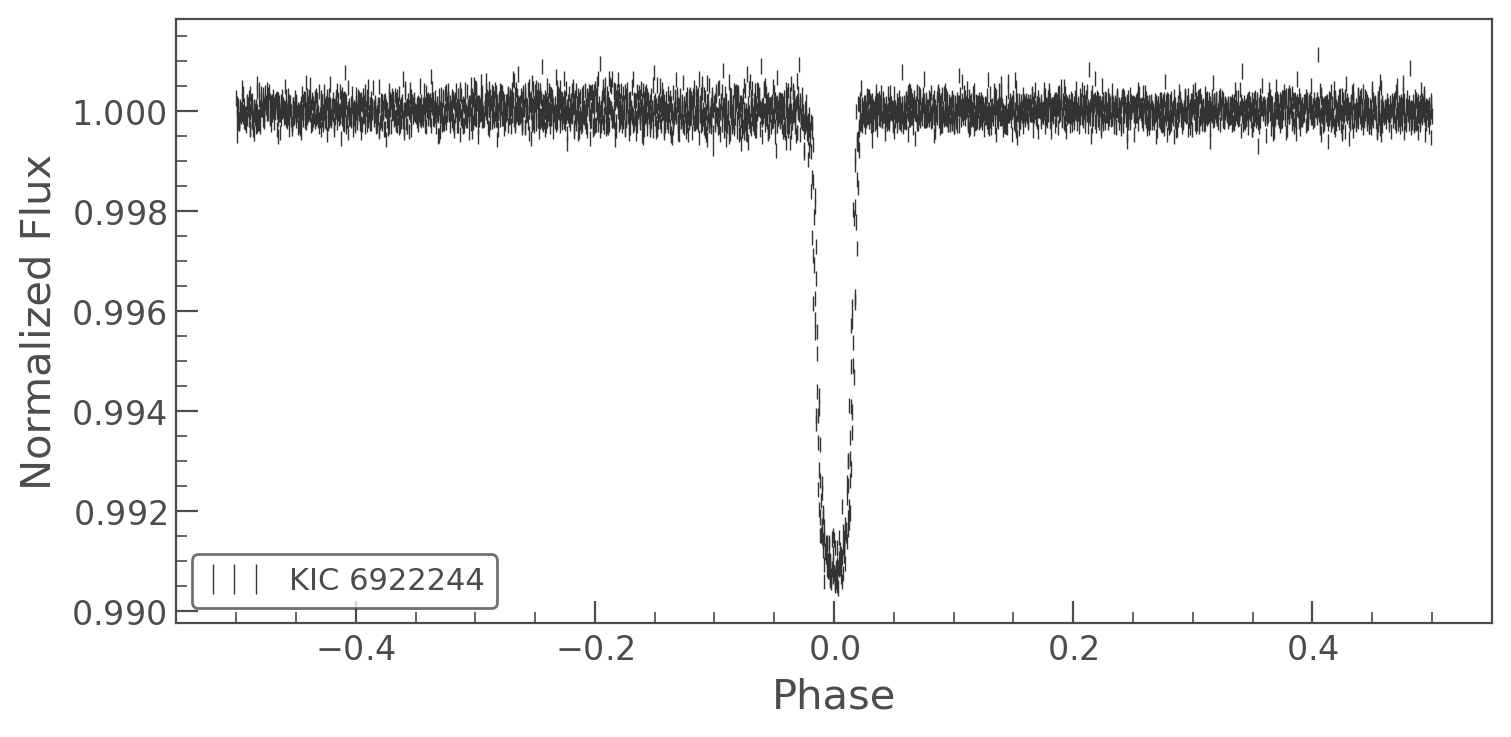

In [ ]:
lc.fold(period, t0).errorbar()

Kepler-8 is a very deep planet transit (1%!) and so it is very easy to find with BLS. For shallower transits, it is worth iterating over a few of your detrending assumptions in order to find the strongest signal.

### 7.2 Interactively searching with BLS

Lightkurve now has the new `interact_bls` method, which will let perform a BLS search with an interactive widget. This is useful for exploring the data and looking for transiting planets on a case by case basis.

In [ ]:
lc.normalize().interact_bls('http://localhost:8987') # This will fail if running from google collab, but will work if you run locally!

### 8. Troubleshooting and Contributing

Lightkurve is available on [github](github.com/keplerGO/lightkurve). If you have problems when using lightkurve, or think you've found a bug, please go ahead and submit an issue to our github describing the problem. We will try to get back to you quickly and fix your issue! If you would like to contribute a new feature to lightkurve and join our author list, please open a pull request with your new feature and we'll work with you to get it merged into lightkurve.

Congratulations on finishing the tutorial! We also have a full set of tutorials online at our [docs](http://docs.lightkurve.org/) which will go into more detail on all of our features. If you are stuck at any point, check out our full tutorials online.